In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve, auc

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier


<font size="4">
<strong>
Procedure
</strong>
</font>


In this section, we outline the approach for conducting two distinct classification tasks: one for 'IncomeInvestment' and the other for 'AccumulationInvestment', each with 2 classes {0, 1}. The objective is to focus on clients identified as potential buyers in at least one category, excluding those uninterested in investing. The classification process involves evaluating 9 classifiers, selecting the top 5 performers, and employing majority voting to enhance model robustness.

<font size = "4">
    <strong>
Possible future improvements
    </strong>
</font>


A potential enhancement could involve developing a unified classifier with 4 classes, representing all combinations of 'IncomeInvestment' and 'AccumulationInvestment' values: (0,0), (0,1), (1,0), (1,1).



# Data Preparation
<p>We first load the 'DataIntrested.xlsx' dataset and separate the features and labels.</p>


In [2]:
# Import the intresting data
X = pd.read_excel('DataIntrested.xlsx')
X.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,IncomeInvestment,AccumulationInvestment
0,0.531646,0.222172,0.243105,0.693150,0.511975,0.466159,0,1
1,0.759494,0.372410,0.170321,0.484773,0.634001,0.242923,1,0
2,0.189873,0.324649,0.262161,0.496502,0.540590,0.326796,0,1
3,0.645570,0.843975,0.734110,0.856016,0.776977,0.343701,1,1
4,0.303797,0.511827,0.570713,0.743707,0.562851,0.454007,0,1


In [3]:
# Features and labels division
y_II = X.loc[:, 'IncomeInvestment']
y_AI = X.loc[:, 'AccumulationInvestment']
X = X.drop(['IncomeInvestment', 'AccumulationInvestment'], axis = 1) # features

y = y_II # IncomeInvestment label

# IncomeInvestment classification



<h4>Train-Test Split</h4>

We split the dataset into training and testing sets

In [4]:
# Train and Test split -> this will still be the same for the other classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape)
print(X_test.shape)

(2788, 6)
(698, 6)


## Multi-layer Perceptron ##

We initialize an MLP classifier with specific parameters, such as the number of hidden layers and maximum iterations.


In [5]:
# Multi Layer Perceptron only on the clients with at least a preference
mlp_classifier = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=42)

# MLP training
mlp_classifier.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=42)

<h4>Model Evaluation</h4>

We make predictions on the test set and calculate the accuracy and recall scores to evaluate the model's performance.

Accuracy: 0.7535816618911175
Recall score: 0.75
Confusion Matrix:
[[232  74]
 [ 98 294]]


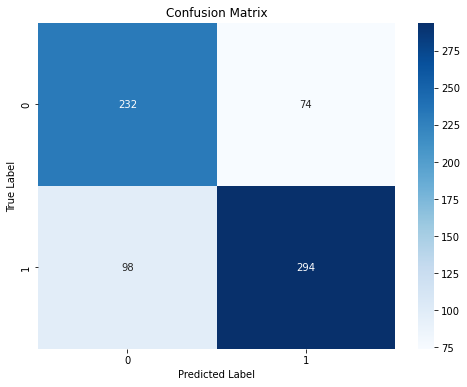

In [6]:
# Prediction on the test set
predictions = mlp_classifier.predict(X_test)

# Accuracy score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Recall score -> True_positive/(True_positive + False_positive) -> what we want to maximize
recall = recall_score(y_test, predictions)
print("Recall score:", recall)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

The accuracy score measures the overall correctness of the predictions, while the recall score focuses on the proportion of true positives that are correctly identified by the model.

<h4>Saving the Predictions</h4>

Finally, we create a new DataFrame that includes the test set features and the MLP model's predictions.

In [7]:
# Save the predictions
dataset_with_predictions = X_test.copy()
dataset_with_predictions['MLP IncomeInvestment'] = predictions
dataset_with_predictions.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,MLP IncomeInvestment
179,0.518987,0.119366,0.166095,0.499077,0.447003,0.405424,1
2153,0.759494,0.568503,0.617078,0.902076,0.764515,0.381090,1
3234,0.582278,0.615310,0.398159,0.658283,0.661516,0.322413,1
184,0.582278,0.545493,0.482318,0.627178,0.580825,0.370585,1
1071,0.341772,0.610581,0.531877,0.845886,0.595056,0.487633,0


## Random Forest

In this section, we train a Random Forest Classifier on the dataset to predict the 'IncomeInvestment' label.

<h4>Defining Parameters</h4>

We start by setting the parameters for the Random Forest Classifier. These parameters include the number of trees in the forest, the maximum depth of each tree, the minimum number of samples required to split a node, the minimum number of samples required at each leaf node, and the minimum impurity decrease required for a split.


In [8]:
# Parameters
n_estimators = 50
max_depth = 50
min_samples_split = 10
min_samples_leaf = 10
min_impurity_decrease = 0
parameters = {"n_estimators": n_estimators,
              "max_depth": max_depth,
              "min_samples_split": min_samples_split,
              "min_samples_leaf": min_samples_leaf,
              "min_impurity_decrease": min_impurity_decrease,
             }

<h4>Training the Classifier</h4>

We create an instance of the Random Forest Classifier using the specified parameters and train it on the training set.

In [9]:
# Training
random_forest = RandomForestClassifier(**parameters, random_state=42)
random_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, min_impurity_decrease=0,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=50, random_state=42)

<h4>Making Predictions</h4>

After training the classifier, we use it to make predictions on the test set.


In [10]:
predictions = random_forest.predict(X_test)

<h4>Evaluating Performance</h4>

To evaluate the performance of the trained classifier, we calculate the accuracy score and recall score on the test set predictions.


Accuracy: 0.7679083094555874
Recall score: 0.7678571428571429
Confusion Matrix:
[[235  71]
 [ 91 301]]


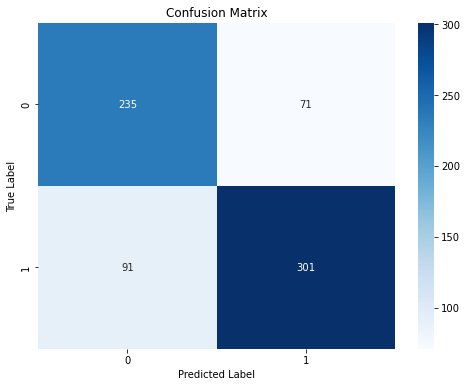

In [11]:
# Accuracy score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Recall score
recall = recall_score(y_test, predictions)
print("Recall score:", recall)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

<h4>Feature Importance</h4>

We extract the feature importances from the trained Random Forest Classifier to determine which features contribute the most to the predictions.


In [12]:
# Features importance (impurity based)
importances = random_forest.feature_importances_
# Dictionary of features and their importance
feature_importance_dict = {X.columns[i] : importances[i] for i in range(len(importances))}
for feat, imp in feature_importance_dict.items():
    print(f'{feat}:{imp}')

Age:0.18823737107524552
FinancialEducation:0.05976056498610295
RiskPropensity:0.06246219371472083
Income:0.08433245201812727
Wealth:0.24733979916920742
Income/Wealth:0.357867619036596


The feature importances are based on the impurity-based criterion, which measures the decrease in impurity (e.g., Gini impurity or information gain) when a feature is used to split a node in a tree.

<h4>Saving Predictions</h4>

Finally, we create a new DataFrame that includes the test set features and the Random Forest Classifier's predictions.


In [13]:
dataset_with_predictions['RF IncomeInvestment'] = predictions
dataset_with_predictions.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,MLP IncomeInvestment,RF IncomeInvestment
179,0.518987,0.119366,0.166095,0.499077,0.447003,0.405424,1,1
2153,0.759494,0.568503,0.617078,0.902076,0.764515,0.381090,1,1
3234,0.582278,0.615310,0.398159,0.658283,0.661516,0.322413,1,1
184,0.582278,0.545493,0.482318,0.627178,0.580825,0.370585,1,1
1071,0.341772,0.610581,0.531877,0.845886,0.595056,0.487633,0,0


## Logistic Regression

We create an instance of the Logistic Regression model and fit it on the training data.


In [14]:
# Creating the logistic regression model
model = LogisticRegression()

# Fitting the model on the training data
model.fit(X_train, y_train)

LogisticRegression()

<h4>Making Predictions and Calculating Metrics</h4>

We make predictions on the testing data using the trained model and calculate accuracy and recall scores.

In [15]:
# Making predictions on the testing data
y_pred = model.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculating recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

Accuracy: 0.7363896848137536
Recall: 0.7704081632653061


<h4>ROC Curve and AUC Score</h4>

We calculate the ROC curve and AUC score to evaluate the model's performance.


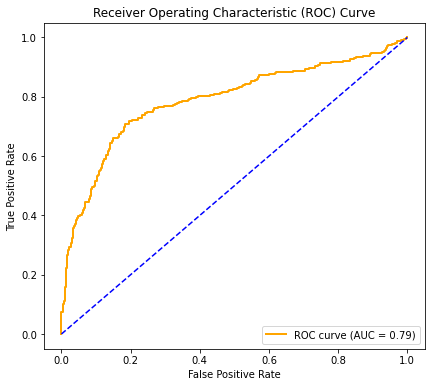

In [16]:
# Calculating ROC curve and AUC score
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plotting ROC curve
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

The ROC curve visualizes the trade-off between the true positive rate and false positive rate at various threshold settings. The AUC score summarizes the ROC curve into a single value, representing the probability that the model will rank a randomly chosen positive instance higher than a randomly chosen negative instance.

<h4>Precision-Recall Curve</h4>

We also calculate the precision-recall curve to evaluate the model's performance.


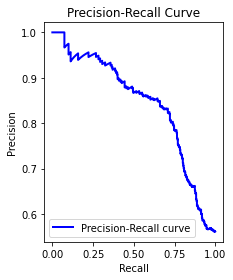

In [17]:
# Calculating precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob)

# Plotting precision-recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

The precision-recall curve visualizes the trade-off between precision and recall at various threshold settings. It is particularly useful when dealing with imbalanced datasets, as it focuses on the performance on the positive class.


<h4>Optimal Threshold Selection</h4>

We find the optimal threshold that maximizes the accuracy on the ROC curve and the point closest to the top-right corner of the precision-recall curve.


In [18]:
# Find the point closest to the top-left corner of the ROC curve
min_distance = float('inf')
optimal_threshold_roc = None
optimal_tpr_roc = None
optimal_fpr_roc = None

for i in range(len(fpr)):
    distance = ((fpr[i])**2 + (1 - tpr[i])**2)**0.5  # Euclidean distance form (0,1)
    if distance < min_distance:
        min_distance = distance
        optimal_threshold_roc = thresholds_roc[i]
        optimal_tpr_roc = tpr[i]
        optimal_fpr_roc = fpr[i]

print("Optimal Threshold_ROC:", optimal_threshold_roc) # This should maximize the accuracy
print("Corresponding TPR:", optimal_tpr_roc)
print("Corresponding FPR:", optimal_fpr_roc)

# Find the point closest to the top-right corner of the precision-recall curve
min_distance = float('inf')
optimal_threshold_pr = None
optimal_precision = None
optimal_recall = None

for i in range(len(precision)):
    distance = ((1 - recall[i])**2 + (1 - precision[i])**2)**0.5  # Euclidean distance formula
    if distance < min_distance:
        min_distance = distance
        optimal_threshold_pr = thresholds_pr[i]
        optimal_precision = precision[i]
        optimal_recall = recall[i]

print("Optimal Threshold for balancing precision and recall:", optimal_threshold_pr)
print("Corresponding Precision:", optimal_precision)
print("Corresponding Recall:", optimal_recall)

Optimal Threshold_ROC: 0.5669424342984343
Corresponding TPR: 0.7193877551020408
Corresponding FPR: 0.19607843137254902
Optimal Threshold for balancing precision and recall: 0.5182130369476059
Corresponding Precision: 0.7847769028871391
Corresponding Recall: 0.7627551020408163


We select the optimal threshold based on the specific requirements of the problem. In this case, since the goal is to identify clients more likely to invest, we prioritize recall over accuracy.

<h4>Making Predictions with Optimal Thresholds</h4>

We make predictions using the optimal thresholds from the ROC curve and precision-recall curve.

In [19]:
# Predictions using the optimal threshold from the roc-curv
# Getting predicted probabilities
y_prob = model.predict_proba(X_test)[:, 1]

# Making predictions based on the adjusted threshold
y_pred_opt_roc = (y_prob >= optimal_threshold_roc).astype(int)

# Predictions using the optimal threshold from the precision-recall curve
# Getting predicted probabilities
y_prob = model.predict_proba(X_test)[:, 1]

# Making predictions based on the adjusted threshold
y_pred_opt_pr = (y_prob >= optimal_threshold_pr).astype(int)

We compare the confusion matrices for the default threshold (0.5), the optimal threshold from the ROC curve, and the optimal threshold from the precision-recall curve.


Confusion Matrix (threshold = 0.5):
[[212  94]
 [ 90 302]]
Confusion Matrix (threshold = optimal_roc):
[[246  60]
 [110 282]]
Confusion Matrix (threshold = optimal_pr):
[[224  82]
 [ 93 299]]


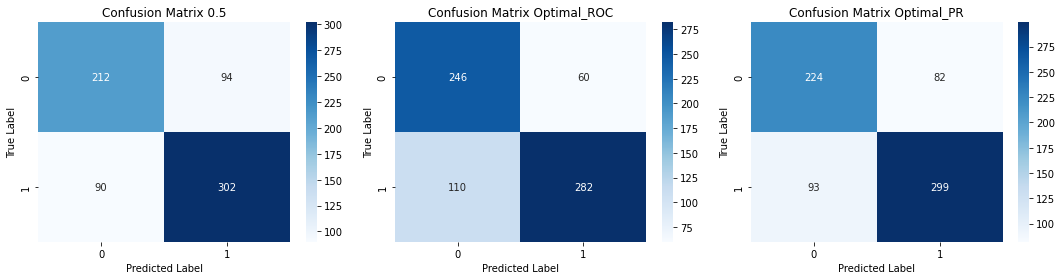

In [20]:
# Plot confusion matrix with three thresholds: 0.5/optimal_roc/optimal_pr
plt.figure(figsize = (15, 4))

plt.subplot(1, 3, 1)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (threshold = 0.5):")
print(conf_matrix)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix 0.5")

plt.subplot(1, 3, 2)
conf_matrix = confusion_matrix(y_test, y_pred_opt_roc)
print("Confusion Matrix (threshold = optimal_roc):")
print(conf_matrix)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Optimal_ROC")

plt.subplot(1, 3, 3)
conf_matrix = confusion_matrix(y_test, y_pred_opt_pr)
print("Confusion Matrix (threshold = optimal_pr):")
print(conf_matrix)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Optimal_PR")

plt.tight_layout()
plt.show()

Based on the analysis, we select the model using the optimal threshold from the precision-recall curve as it prioritizes the identification of clients more likely to invest.


<h4>Saving Predictions</h4>

Finally, we create a new DataFrame that includes the testing set features and the Logistic Regression model's predictions using the optimal threshold from the precision-recall curve.


In [21]:
dataset_with_predictions['LR IncomeInvestment'] = y_pred_opt_pr
dataset_with_predictions.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,MLP IncomeInvestment,RF IncomeInvestment,LR IncomeInvestment
179,0.518987,0.119366,0.166095,0.499077,0.447003,0.405424,1,1,1
2153,0.759494,0.568503,0.617078,0.902076,0.764515,0.381090,1,1,1
3234,0.582278,0.615310,0.398159,0.658283,0.661516,0.322413,1,1,1
184,0.582278,0.545493,0.482318,0.627178,0.580825,0.370585,1,1,1
1071,0.341772,0.610581,0.531877,0.845886,0.595056,0.487633,0,0,0


## K-Nearest Neighbors (KNN)

In this section, we explore the process of training a K-Nearest Neighbors (KNN) model, optimizing the hyperparameter k, and evaluating its performance.


<h4>Hyperparameter Optimization with Cross-Validation</h4>

We start by defining a range of k values to test and perform 10-fold cross-validation for each k to determine the optimal value.


In [22]:
# Define a range of k values to test
k_values = range(1, 50)

# Empty list to store cross-validation scores for each k
cv_scores = []

# Perform 10-fold cross-validation for each k
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_model, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

<h4>Visualizing Cross-Validation Scores</h4>


We plot the cross-validation scores for different values of k to identify the optimal k value.


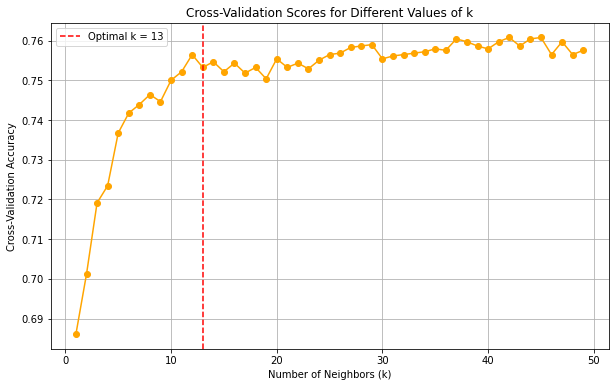

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o', linestyle='-', color='orange')

plt.axvline(x=13, color='r', linestyle='--', label='Optimal k = 13')

plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Scores for Different Values of k')
plt.grid(True)
plt.legend()
plt.show()

<h5>Comment:</h5>   
The elbow point indicates that the optimal k value is around 13, where adding more complexity does not significantly improve accuracy.

<h4>Model Training and Evaluation</h4>

We create the KNN model with the best k value found and evaluate its performance on the testing data.


In [24]:
# Creating the KNN model with the best k found
k_best = 13
knn_model = KNeighborsClassifier(n_neighbors=k_best)

# Fitting the model on the training data
knn_model.fit(X_train, y_train)

# Making predictions on the testing data
y_pred_knn = knn_model.predict(X_test)

# Evaluating the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy:", accuracy_knn)

recall_knn = recall_score(y_test, y_pred_knn)
print("Recall:", recall_knn)

conf_matrix = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7449856733524355
Recall: 0.7168367346938775
Confusion Matrix:
[[239  67]
 [111 281]]


We plot the confusion matrix to visualize the model's performance in predicting the 'IncomeInvestment' label.

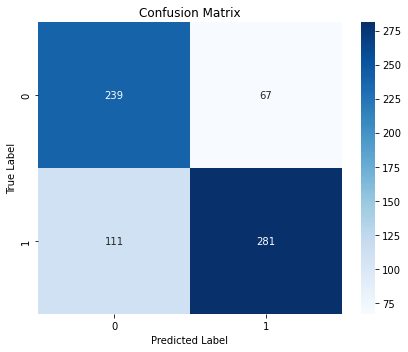

In [25]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

<h4>Saving Predictions</h4>


Finally, we update the dataset with the KNN model's predictions for the 'IncomeInvestment' label.


In [26]:
# Save the predictions
dataset_with_predictions['KNN IncomeInvestment'] = y_pred_knn
dataset_with_predictions.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,MLP IncomeInvestment,RF IncomeInvestment,LR IncomeInvestment,KNN IncomeInvestment
179,0.518987,0.119366,0.166095,0.499077,0.447003,0.405424,1,1,1,1
2153,0.759494,0.568503,0.617078,0.902076,0.764515,0.381090,1,1,1,1
3234,0.582278,0.615310,0.398159,0.658283,0.661516,0.322413,1,1,1,1
184,0.582278,0.545493,0.482318,0.627178,0.580825,0.370585,1,1,1,1
1071,0.341772,0.610581,0.531877,0.845886,0.595056,0.487633,0,0,0,0


**Comment:**  
The elbow is around 10/14 neighboors, after that it's no more convinient adding degrees of complexity since the accuracy gain wouldn't be enough.

## Support Vector Machine (SVM)

In this section, we train a Support Vector Machine (SVM) model to predict the 'IncomeInvestment' label and evaluate its performance.

<h4>Model Initialization</h4>

We start by creating an instance of the SVM model with the 'rbf' kernel and a random state of 42. The kernel and other parameters can be adjusted as needed to optimize the model's performance.


In [27]:
svm_model = SVC(kernel='rbf', random_state=42)

<h4>Model Training</h4>


We fit the SVM model on the training data.


In [28]:
svm_model.fit(X_train, y_train)

SVC(random_state=42)

<h4>Making Predictions</h4>

After training the model, we use it to make predictions on the testing data.


In [29]:
# Making predictions on the testing data
y_pred_svm = svm_model.predict(X_test)

<h4>Model Evaluation</h4>

We evaluate the performance of the SVM model by calculating the accuracy and recall scores on the test set.


In [30]:
# Evaluating the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", accuracy_svm)

recall_svm = recall_score(y_test, y_pred_svm)
print("Recall:", recall_svm)

conf_matrix = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix")
print(conf_matrix)

Accuracy: 0.7507163323782235
Recall: 0.7193877551020408
Confusion Matrix
[[242  64]
 [110 282]]


We visualize the confusion matrix using a heatmap to better understand the model's performance.

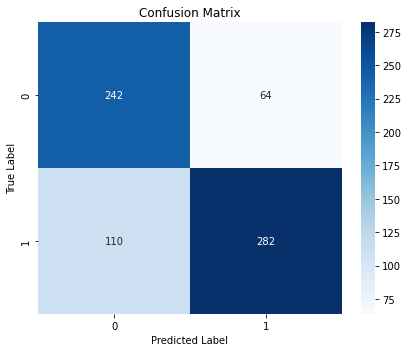

In [31]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.tight_layout()
plt.show()

<h4>Saving Predictions</h4>

Finally, we update the dataset with the SVM model's predictions for the 'IncomeInvestment' label.


In [32]:
# Save the predictions
dataset_with_predictions['SVM IncomeInvestment'] = y_pred_svm
dataset_with_predictions.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,MLP IncomeInvestment,RF IncomeInvestment,LR IncomeInvestment,KNN IncomeInvestment,SVM IncomeInvestment
179,0.518987,0.119366,0.166095,0.499077,0.447003,0.405424,1,1,1,1,1
2153,0.759494,0.568503,0.617078,0.902076,0.764515,0.381090,1,1,1,1,1
3234,0.582278,0.615310,0.398159,0.658283,0.661516,0.322413,1,1,1,1,1
184,0.582278,0.545493,0.482318,0.627178,0.580825,0.370585,1,1,1,1,1
1071,0.341772,0.610581,0.531877,0.845886,0.595056,0.487633,0,0,0,0,0


## Gradient Boosting

In this section, we train a Gradient Boosting Classifier model to predict the 'IncomeInvestment' label and evaluate its performance.

<h4>Model Initialization</h4>

We initialize the Gradient Boosting Classifier with specific parameters such as the number of estimators, learning rate, and maximum depth of the individual regression estimators.


In [33]:
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

<h4>Model Training</h4>

We fit the Gradient Boosting Classifier model on the training data.


In [34]:
gb_classifier.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

<h4>Making Predictions</h4>

After training the model, we use it to make predictions on the testing data.


In [35]:
predictions_gb = gb_classifier.predict(X_test)

<h4>Model Evaluation</h4>

We evaluate the performance of the Gradient Boosting Classifier model by calculating the accuracy and recall scores on the test set.


In [36]:
# Accuracy and Recall
accuracy_gb = accuracy_score(y_test, predictions_gb)
recall_gb = recall_score(y_test, predictions_gb)

# Confusion Matrix
conf_matrix_gb = confusion_matrix(y_test, predictions_gb)

print("Gradient Boosting Classifier Metrics:")
print("Accuracy:", accuracy_gb)
print("Recall score:", recall_gb)
print("Confusion Matrix:")
print(conf_matrix_gb)

Gradient Boosting Classifier Metrics:
Accuracy: 0.7765042979942693
Recall score: 0.7755102040816326
Confusion Matrix:
[[238  68]
 [ 88 304]]


We visualize the confusion matrix using a heatmap to better understand the model's performance.

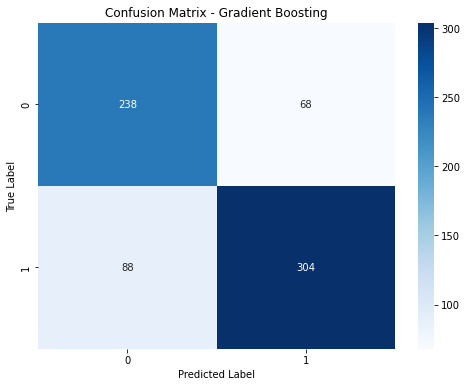

In [37]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gb, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()

<h4>Saving Predictions</h4>


Finally, we update the dataset with the Gradient Boosting Classifier's predictions for the 'IncomeInvestment' label.


In [38]:
# Save the predictions
dataset_with_predictions['GB IncomeInvestment'] = predictions_gb
dataset_with_predictions.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,MLP IncomeInvestment,RF IncomeInvestment,LR IncomeInvestment,KNN IncomeInvestment,SVM IncomeInvestment,GB IncomeInvestment
179,0.518987,0.119366,0.166095,0.499077,0.447003,0.405424,1,1,1,1,1,1
2153,0.759494,0.568503,0.617078,0.902076,0.764515,0.381090,1,1,1,1,1,1
3234,0.582278,0.615310,0.398159,0.658283,0.661516,0.322413,1,1,1,1,1,1
184,0.582278,0.545493,0.482318,0.627178,0.580825,0.370585,1,1,1,1,1,1
1071,0.341772,0.610581,0.531877,0.845886,0.595056,0.487633,0,0,0,0,0,0


## Decision Tree + AdaBoost

In this section, we train an AdaBoost Classifier using a Decision Tree as the base estimator to predict the 'IncomeInvestment' label.

<h4>Initializing the Base Estimator and AdaBoost Classifier</h4>

We start by initializing the base estimator, which in this case is a Decision Tree Classifier with a maximum depth of 1.


In [39]:
base_estimator = DecisionTreeClassifier(max_depth=1)

Next, we initialize the AdaBoost Classifier using the Decision Tree as the base estimator. We set the number of estimators to 50 and the learning rate to 1.0. The random state is set to 42 for reproducibility.

In [40]:
# Initialize AdaBoost with a Decision Tree as the base estimator
ada_classifier = AdaBoostClassifier(n_estimators=50,
                                    learning_rate=1.0,
                                    random_state=42)

<h4>Training the AdaBoost Model</h4>


We fit the AdaBoost Classifier to the training data.


In [41]:
ada_classifier.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

<h4>Making Predictions and Evaluating Performance</h4>

After training the model, we use it to make predictions on the test set.


In [42]:
predictions_ada = ada_classifier.predict(X_test)

We then calculate the accuracy and recall scores to evaluate the model's performance.


In [43]:
# Calculate metrics
accuracy_ada = accuracy_score(y_test, predictions_ada)
recall_ada = recall_score(y_test, predictions_ada)

# Generating the confusion matrix
conf_matrix_ada = confusion_matrix(y_test, predictions_ada)

print("AdaBoost with Decision Tree Classifier Metrics:")
print("Accuracy:", accuracy_ada)
print("Recall score:", recall_ada)
print("Confusion Matrix:")
print(conf_matrix_ada)

AdaBoost with Decision Tree Classifier Metrics:
Accuracy: 0.7679083094555874
Recall score: 0.7806122448979592
Confusion Matrix:
[[230  76]
 [ 86 306]]


We visualize the confusion matrix using a heatmap to better understand the model's performance.

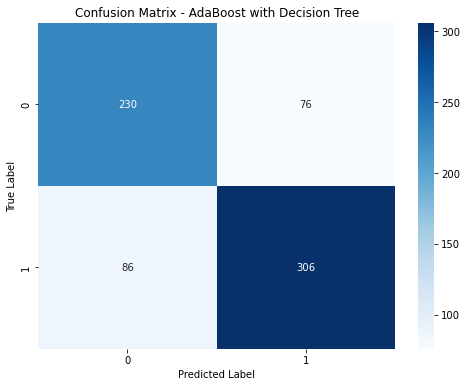

In [44]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ada, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - AdaBoost with Decision Tree")
plt.show()

<h4>Saving Predictions</h4>

Finally, we create a new column in the dataset with the AdaBoost Classifier's predictions for the 'IncomeInvestment' label.

In [45]:
dataset_with_predictions['DT+Ada IncomeInvestment'] = predictions_ada
dataset_with_predictions.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,MLP IncomeInvestment,RF IncomeInvestment,LR IncomeInvestment,KNN IncomeInvestment,SVM IncomeInvestment,GB IncomeInvestment,DT+Ada IncomeInvestment
179,0.518987,0.119366,0.166095,0.499077,0.447003,0.405424,1,1,1,1,1,1,1
2153,0.759494,0.568503,0.617078,0.902076,0.764515,0.381090,1,1,1,1,1,1,1
3234,0.582278,0.615310,0.398159,0.658283,0.661516,0.322413,1,1,1,1,1,1,1
184,0.582278,0.545493,0.482318,0.627178,0.580825,0.370585,1,1,1,1,1,1,1
1071,0.341772,0.610581,0.531877,0.845886,0.595056,0.487633,0,0,0,0,0,0,0


## Naïve Bayes

In this section, we train a Gaussian Naive Bayes Classifier to predict the 'IncomeInvestment' label.

<h4>Model Initialization</h4>

We start by creating an instance of the Gaussian Naive Bayes Classifier

In [46]:
nb_classifier = GaussianNB()

<h4>Model Training</h4>

We fit the Naive Bayes Classifier to the training data using the fit method.


In [47]:
nb_classifier.fit(X_train, y_train)

GaussianNB()

<h4>Making Predictions</h4>

After training the model, we use it to make predictions on the test set using the predict method.


In [48]:
predictions_nb = nb_classifier.predict(X_test)

<h4>Model Evaluation</h4>

To evaluate the performance of the trained Naive Bayes Classifier, we calculate the accuracy and recall scores on the test set predictions.


In [49]:
# Calculate metrics
accuracy_nb = accuracy_score(y_test, predictions_nb)
recall_nb = recall_score(y_test, predictions_nb)

# Confusion Matrix
conf_matrix_nb = confusion_matrix(y_test, predictions_nb)

print("Naive Bayes Classifier Metrics:")
print("Accuracy:", accuracy_nb)
print("Recall score:", recall_nb)
print("Confusion Matrix:")
print(conf_matrix_nb)

Naive Bayes Classifier Metrics:
Accuracy: 0.7335243553008596
Recall score: 0.7040816326530612
Confusion Matrix:
[[236  70]
 [116 276]]


We visualize the confusion matrix using a heatmap to better understand the model's performance.

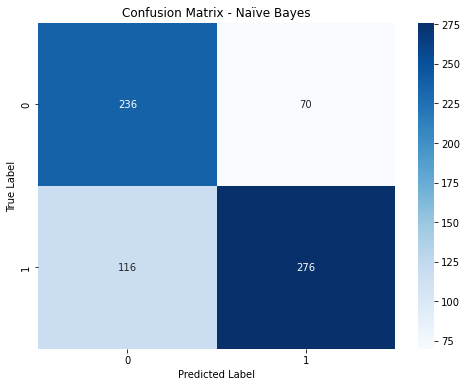

In [50]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Naïve Bayes")
plt.show()

<h4>Saving Predictions</h4>

Finally, we create a new column in the dataset with the Naive Bayes Classifier's predictions for the 'IncomeInvestment' label.


In [51]:
dataset_with_predictions['NB IncomeInvestment'] = predictions_nb
dataset_with_predictions.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,MLP IncomeInvestment,RF IncomeInvestment,LR IncomeInvestment,KNN IncomeInvestment,SVM IncomeInvestment,GB IncomeInvestment,DT+Ada IncomeInvestment,NB IncomeInvestment
179,0.518987,0.119366,0.166095,0.499077,0.447003,0.405424,1,1,1,1,1,1,1,0
2153,0.759494,0.568503,0.617078,0.902076,0.764515,0.381090,1,1,1,1,1,1,1,1
3234,0.582278,0.615310,0.398159,0.658283,0.661516,0.322413,1,1,1,1,1,1,1,1
184,0.582278,0.545493,0.482318,0.627178,0.580825,0.370585,1,1,1,1,1,1,1,1
1071,0.341772,0.610581,0.531877,0.845886,0.595056,0.487633,0,0,0,0,0,0,0,0


## XGBoost

In this section, we train an XGBoost Classifier to predict the 'IncomeInvestment' label.


<h4>Model Initialization</h4>

We start by creating an instance of the XGBoost Classifier using the XGBClassifier class from the xgboost library. We set the use_label_encoder parameter to False to avoid using the default label encoder, and set the eval_metric parameter to 'logloss' to use the log loss as the evaluation metric. The random_state parameter is set to 42 for reproducibility.


In [52]:
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

<h4>Model Training</h4>

We fit the XGBoost Classifier to the training data using the fit method.


In [53]:
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

<h4>Making Predictions</h4>

After training the model, we use it to make predictions on the test set using the predict method.


In [54]:
predictions_xgb = xgb_classifier.predict(X_test)

<h4>Model Evaluation</h4>

To evaluate the performance of the trained XGBoost Classifier, we calculate the accuracy and recall scores on the test set predictions.


In [55]:
# Calculate metrics
accuracy_xgb = accuracy_score(y_test, predictions_xgb)
recall_xgb = recall_score(y_test, predictions_xgb)

# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test, predictions_xgb)

print("XGBoost Classifier Metrics:")
print("Accuracy:", accuracy_xgb)
print("Recall score:", recall_xgb)
print("Confusion Matrix:")
print(conf_matrix_xgb)

XGBoost Classifier Metrics:
Accuracy: 0.7478510028653295
Recall score: 0.7372448979591837
Confusion Matrix:
[[233  73]
 [103 289]]


We visualize the confusion matrix using a heatmap to better understand the model's performance.

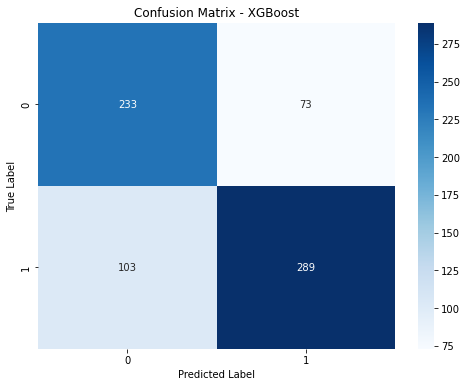

In [56]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost")
plt.show()

<h4>Saving Predictions</h4>

Finally, we create a new column in the dataset with the XGBoost Classifier's predictions for the 'IncomeInvestment' label.


In [57]:
dataset_with_predictions['XGB IncomeInvestment'] = predictions_xgb
dataset_with_predictions.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,MLP IncomeInvestment,RF IncomeInvestment,LR IncomeInvestment,KNN IncomeInvestment,SVM IncomeInvestment,GB IncomeInvestment,DT+Ada IncomeInvestment,NB IncomeInvestment,XGB IncomeInvestment
179,0.518987,0.119366,0.166095,0.499077,0.447003,0.405424,1,1,1,1,1,1,1,0,1
2153,0.759494,0.568503,0.617078,0.902076,0.764515,0.381090,1,1,1,1,1,1,1,1,1
3234,0.582278,0.615310,0.398159,0.658283,0.661516,0.322413,1,1,1,1,1,1,1,1,1
184,0.582278,0.545493,0.482318,0.627178,0.580825,0.370585,1,1,1,1,1,1,1,1,0
1071,0.341772,0.610581,0.531877,0.845886,0.595056,0.487633,0,0,0,0,0,0,0,0,0


## Ensemble Modeling and Bagging

In this final section, we combine the predictions from multiple models using a bagging approach to obtain a more robust and accurate prediction for the 'IncomeInvestment' label.


<h4>Extracting Predictions from Individual Models</h4>

We first extract the predictions from the 9 individual models into a separate DataFrame.


In [58]:
predictions_from_models = dataset_with_predictions.iloc[:, -9:]

<h4>Majority Voting Bagging</h4>

We perform majority voting bagging using the predictions from the 5 models with the highest recall scores: MLP, IF, LR, GB, and DT+ADA.


In [59]:
# Calculate the mode along the columns axis for each row
# Using the best classifiers in term of biggest recall -> MLP, IF, LR, GB, DT+ADA
bagging_predictions = predictions_from_models.iloc[:, [0, 1, 2, 5, 6]].mode(axis=1)

# Add 'Bagging' column to dataset_with_predictions DataFrame
dataset_with_predictions['Bagging'] = bagging_predictions.iloc[:, 0]

<h4>Evaluating the Bagging Model</h4>

We evaluate the performance of the bagging model by calculating the accuracy and recall scores on the test set predictions.


Accuracy: 0.7765042979942693
Recall: 0.7882653061224489
Confusion Matrix
[[233  73]
 [ 83 309]]


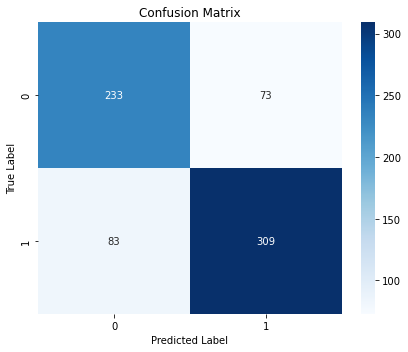

In [60]:
# Evaluating the overall model
accuracy_bagging = accuracy_score(y_test, dataset_with_predictions['Bagging'])
print("Accuracy:", accuracy_bagging)

recall_bagging = recall_score(y_test, dataset_with_predictions['Bagging'])
print("Recall:", recall_bagging)

conf_matrix = confusion_matrix(y_test, dataset_with_predictions['Bagging'])
print("Confusion Matrix")
print(conf_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.tight_layout()
plt.show()

<h4>Comment:</h4>
<p>The aim of bagging is to make the model more robust by combining predictions from multiple models, particularly through majority voting. It is observable that the ensemble approach outperforms almost all the individual models.</p>
<p>While bagging aims to improve robustness, its effectiveness may vary depending on the individual models being combined and their respective strengths. This is the reason behind our selection of the 5 best algorithms out of the 9 based on recall scores.</p>  
<p>With this choice, our goal is to obtain a more stable model with reduced variance, which can be useful in scenarios where robust predictions are desired or when dealing with noisy or uncertain datasets.</p>

<h4>Saving the Predictions</h4>

Finally, we save the dataset containing the bagging model's predictions for the 'IncomeInvestment' label.


In [61]:
excel_file_path = "IncomeInvestment_Predictions.xlsx"

dataset_with_predictions.to_excel(excel_file_path, index=False)

# AccumulationInvestment classification

Now we will perform the same classification tasks that has been done for the 'IncomeInvestment' label.
Notice that the procedure is exaclty the same, so to not be redundant and to let the notebook be less heavy we didn't comment in detail this part so for well commented code, please check the IncomeInvestment classification section.

In [62]:
# Train and test split -> let's mantain the same index of the split done for the IncomeInvestment classification
X_train, X_test
y_train = y_AI.loc[X_train.index]
y_test = y_AI.loc[X_test.index]

## Multilayer perceptron

Accuracy: 0.7521489971346705
Recall score: 0.8655804480651731
Confusion Matrix:
[[100 107]
 [ 66 425]]


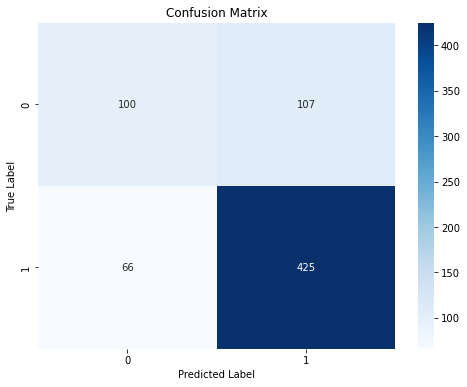

In [63]:
# Multi Layer Perceptron only on the clients with at least a preference
mlp_classifier = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=1000, random_state=42)

# MLP training
mlp_classifier.fit(X_train, y_train)

# Prediction on the test set
predictions = mlp_classifier.predict(X_test)

# Accuracy score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Recall score -> True_positive/(True_positive + False_positive) -> what we want to maximize
recall = recall_score(y_test, predictions)
print("Recall score:", recall)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
#plt.savefig('ConfusionMatrix_IncomeInvestmentReduced.png')
plt.show()

In [64]:
# Save the predictions
dataset_with_predictions = X_test.copy()
dataset_with_predictions['MLP AccumulationInvestment'] = predictions
dataset_with_predictions.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,MLP AccumulationInvestment
179,0.518987,0.119366,0.166095,0.499077,0.447003,0.405424,1
2153,0.759494,0.568503,0.617078,0.902076,0.764515,0.381090,1
3234,0.582278,0.615310,0.398159,0.658283,0.661516,0.322413,0
184,0.582278,0.545493,0.482318,0.627178,0.580825,0.370585,1
1071,0.341772,0.610581,0.531877,0.845886,0.595056,0.487633,1


## Random Forest

Accuracy: 0.7822349570200573
Recall score: 0.9022403258655805
Confusion Matrix:
[[103 104]
 [ 48 443]]


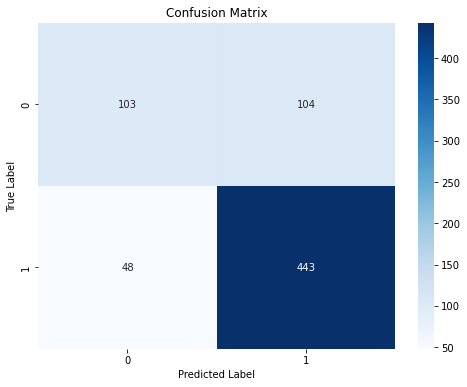

In [65]:
# First attempt without CV
# Parameters
n_estimators = 50
max_depth = 50
min_samples_split = 10
min_samples_leaf = 10
min_impurity_decrease = 0
parameters = {"n_estimators": n_estimators,
      "max_depth": max_depth,
      "min_samples_split": min_samples_split,
      "min_samples_leaf": min_samples_leaf,
     "min_impurity_decrease": min_impurity_decrease,
       }
random_forest = RandomForestClassifier(**parameters, random_state=42)

# Training
random_forest.fit(X_train, y_train)

# Prevision
predictions = random_forest.predict(X_test)

# Accuracy score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Recall score
recall = recall_score(y_test, predictions)
print("Recall score:", recall)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [66]:
# Features importance (impurity based)
importances = random_forest.feature_importances_
# Dictionary of features and their immportance
feature_importance_dict = {X.columns[i] : importances[i] for i in range(len(importances))}
for feat, imp in feature_importance_dict.items():
    print(f'{feat}:{imp}')

# Income/Wealth:0.319; Wealth:0.246; Age:0.135; Income: 0.135

Age:0.13485717537885888
FinancialEducation:0.08256271497259073
RiskPropensity:0.08169738822778998
Income:0.1348242664765318
Wealth:0.24645456686819966
Income/Wealth:0.319603888076029


In [67]:
# Save the predictions
dataset_with_predictions['RF AccumulationInvestment'] = predictions
dataset_with_predictions.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,MLP AccumulationInvestment,RF AccumulationInvestment
179,0.518987,0.119366,0.166095,0.499077,0.447003,0.405424,1,0
2153,0.759494,0.568503,0.617078,0.902076,0.764515,0.381090,1,1
3234,0.582278,0.615310,0.398159,0.658283,0.661516,0.322413,0,1
184,0.582278,0.545493,0.482318,0.627178,0.580825,0.370585,1,1
1071,0.341772,0.610581,0.531877,0.845886,0.595056,0.487633,1,1


## Logistic Regression

In [68]:
# Creating the logistic regression model
model = LogisticRegression()

# Fitting the model on the training data
model.fit(X_train, y_train)

# Making predictions on the testing data
y_pred = model.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculating recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

Accuracy: 0.7077363896848138
Recall: 0.9775967413441955


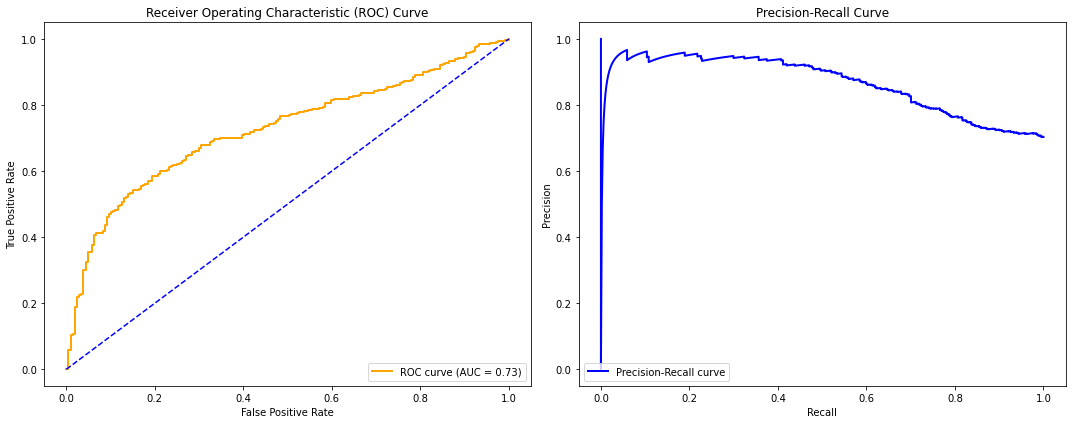

In [69]:
# Calculating ROC curve and AUC score
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plotting ROC curve
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Calculating precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob)

# Plotting precision-recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

In [70]:
# Find the point closest to the top-left corner of the ROC curve
min_distance = float('inf')
optimal_threshold_roc = None
optimal_tpr_roc = None
optimal_fpr_roc = None

for i in range(len(fpr)):
    distance = ((fpr[i])**2 + (1 - tpr[i])**2)**0.5  # Euclidean distance form (0,1)
    if distance < min_distance:
        min_distance = distance
        optimal_threshold_roc = thresholds_roc[i]
        optimal_tpr_roc = tpr[i]
        optimal_fpr_roc = fpr[i]

print("Optimal Threshold_ROC:", optimal_threshold_roc) # This should maximize the accuracy
print("Corresponding TPR:", optimal_tpr_roc)
print("Corresponding FPR:", optimal_fpr_roc)

Optimal Threshold_ROC: 0.7467238312029655
Corresponding TPR: 0.6782077393075356
Corresponding FPR: 0.30434782608695654


In [71]:
# Predictions using the optimal threshold from the roc-curv
# Getting predicted probabilities
y_prob = model.predict_proba(X_test)[:, 1]

# Making predictions based on the adjusted threshold
y_pred_opt_roc = (y_prob >= optimal_threshold_roc).astype(int)

In [72]:
# Find the point closest to the top-right corner of the precision-recall curve
min_distance = float('inf')
optimal_threshold_pr = None
optimal_precision = None
optimal_recall = None

for i in range(len(precision)):
    distance = ((1 - recall[i])**2 + (1 - precision[i])**2)**0.5  # Euclidean distance formula
    if distance < min_distance:
        min_distance = distance
        optimal_threshold_pr = thresholds_pr[i]
        optimal_precision = precision[i]
        optimal_recall = recall[i]

print("Optimal Threshold for balancing precision and recall:", optimal_threshold_pr)
print("Corresponding Precision:", optimal_precision)
print("Corresponding Recall:", optimal_recall)

Optimal Threshold for balancing precision and recall: 0.4818428792261889
Corresponding Precision: 0.7144970414201184
Corresponding Recall: 0.9837067209775967


In [73]:
# Predictions using the optimal threshold from the precision-recall curve
# Getting predicted probabilities
y_prob = model.predict_proba(X_test)[:, 1]

# Making predictions based on the adjusted threshold
y_pred_opt_pr = (y_prob >= optimal_threshold_pr).astype(int)

Confusion Matrix (threshold = 0.5):
[[ 14 193]
 [ 11 480]]
Confusion Matrix (threshold = 0.7467238312029655):
[[144  63]
 [158 333]]
Confusion Matrix (threshold = 0.4818428792261889):
[[ 14 193]
 [  8 483]]


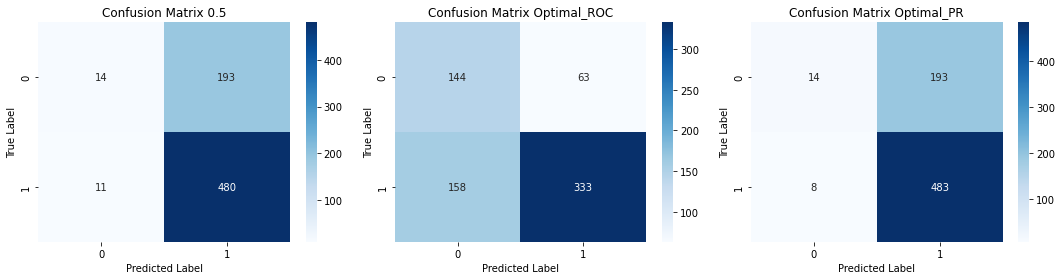

In [74]:
# Plot confusion matrix with three thresholds: 0.5/optimal_roc/optimal_pr
plt.figure(figsize = (15, 4))

plt.subplot(1, 3, 1)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (threshold = 0.5):")
print(conf_matrix)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix 0.5")

plt.subplot(1, 3, 2)
conf_matrix = confusion_matrix(y_test, y_pred_opt_roc)
print("Confusion Matrix (threshold = 0.7467238312029655):")
print(conf_matrix)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Optimal_ROC")

plt.subplot(1, 3, 3)
conf_matrix = confusion_matrix(y_test, y_pred_opt_pr)
print("Confusion Matrix (threshold = 0.4818428792261889):")
print(conf_matrix)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Optimal_PR")

plt.tight_layout()
plt.show()

**Comment:**
  
Even though the last model (i.e., the model closest to the top right corner of the precision-recall space) has less accuracy in predicting the negative class, we choose it because our main focus is to sell.
Therefore, we aim to identify potential customers, who are represented by the positive class.


In [75]:
# Save the predictions
dataset_with_predictions['LR AccumulationInvestment'] = y_pred_opt_pr
dataset_with_predictions.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,MLP AccumulationInvestment,RF AccumulationInvestment,LR AccumulationInvestment
179,0.518987,0.119366,0.166095,0.499077,0.447003,0.405424,1,0,1
2153,0.759494,0.568503,0.617078,0.902076,0.764515,0.381090,1,1,1
3234,0.582278,0.615310,0.398159,0.658283,0.661516,0.322413,0,1,1
184,0.582278,0.545493,0.482318,0.627178,0.580825,0.370585,1,1,1
1071,0.341772,0.610581,0.531877,0.845886,0.595056,0.487633,1,1,1


## K-Nearest Neighbors

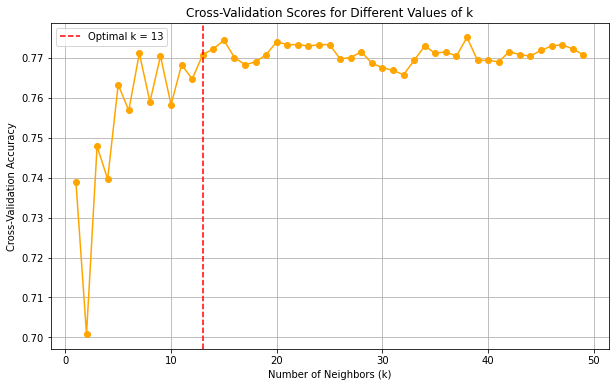

In [76]:
# Define a range of k values to test
k_values = range(1, 50)  # Example: Test k values from 1 to 20

# Empty list to store cross-validation scores for each k
cv_scores = []

# Perform 10-fold cross-validation for each k
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_model, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())


# Plotting the cross-validation scores for each k
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o', linestyle='-', color='orange')

plt.axvline(x=13, color='r', linestyle='--', label='Optimal k = 13')

plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Scores for Different Values of k')
plt.grid(True)
plt.legend()
plt.show()

In [77]:
# Creating the KNN model with the best K found
k_best = 13
knn_model = KNeighborsClassifier(n_neighbors=k_best)

# Fitting the model on the training data
knn_model.fit(X_train, y_train)

# Making predictions on the testing data
y_pred_knn = knn_model.predict(X_test)

Accuracy: 0.7693409742120344
Recall: 0.924643584521385
Confusion Matrix
[[ 83 124]
 [ 37 454]]


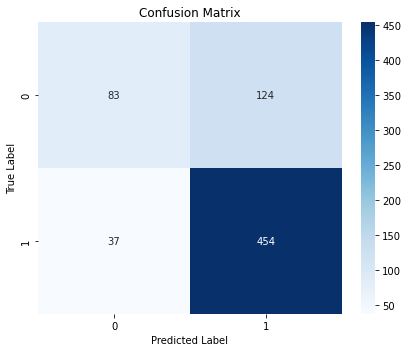

In [78]:
# Evaluating the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy:", accuracy_knn)

recall_knn = recall_score(y_test, y_pred_knn)
print("Recall:", recall_knn)

conf_matrix = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix")
print(conf_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.tight_layout()
plt.show()

In [79]:
# Save the predictions
dataset_with_predictions['KNN AccumulationInvestment'] = y_pred_knn
dataset_with_predictions.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,MLP AccumulationInvestment,RF AccumulationInvestment,LR AccumulationInvestment,KNN AccumulationInvestment
179,0.518987,0.119366,0.166095,0.499077,0.447003,0.405424,1,0,1,1
2153,0.759494,0.568503,0.617078,0.902076,0.764515,0.381090,1,1,1,1
3234,0.582278,0.615310,0.398159,0.658283,0.661516,0.322413,0,1,1,1
184,0.582278,0.545493,0.482318,0.627178,0.580825,0.370585,1,1,1,1
1071,0.341772,0.610581,0.531877,0.845886,0.595056,0.487633,1,1,1,1


## Support Vector Machine (SVM)

Accuracy: 0.7349570200573066
Recall: 0.9572301425661914
Confusion Matrix
[[ 43 164]
 [ 21 470]]


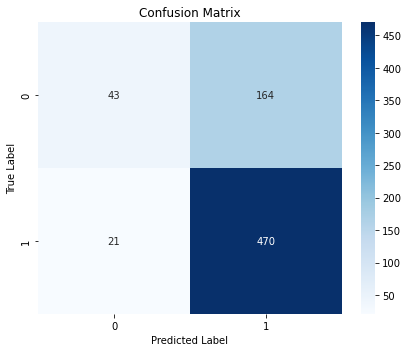

In [80]:
# Creating the SVM model
svm_model = SVC(kernel='rbf', random_state=42)  # You can adjust the kernel and other parameters as needed

# Fitting the model on the training data
svm_model.fit(X_train, y_train)

# Making predictions on the testing data
y_pred_svm = svm_model.predict(X_test)

# Evaluating the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", accuracy_svm)

recall_svm = recall_score(y_test, y_pred_svm)
print("Recall:", recall_svm)

conf_matrix = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix")
print(conf_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.tight_layout()
plt.show()

In [81]:
# Save the predictions
dataset_with_predictions['SVM AccumulationInvestment'] = y_pred_svm
dataset_with_predictions.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,MLP AccumulationInvestment,RF AccumulationInvestment,LR AccumulationInvestment,KNN AccumulationInvestment,SVM AccumulationInvestment
179,0.518987,0.119366,0.166095,0.499077,0.447003,0.405424,1,0,1,1,1
2153,0.759494,0.568503,0.617078,0.902076,0.764515,0.381090,1,1,1,1,1
3234,0.582278,0.615310,0.398159,0.658283,0.661516,0.322413,0,1,1,1,1
184,0.582278,0.545493,0.482318,0.627178,0.580825,0.370585,1,1,1,1,1
1071,0.341772,0.610581,0.531877,0.845886,0.595056,0.487633,1,1,1,1,1


## Gradient Boosting

Gradient Boosting Classifier Metrics:
Accuracy: 0.7851002865329513
Recall score: 0.9042769857433809
Confusion Matrix:
[[104 103]
 [ 47 444]]


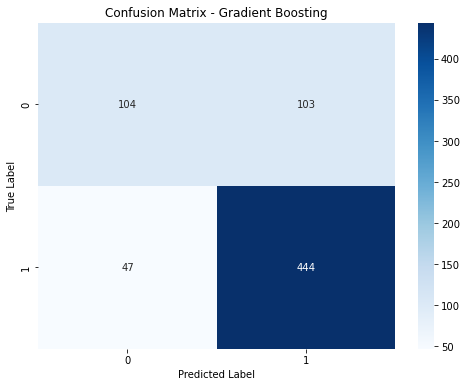

In [82]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Training the model
gb_classifier.fit(X_train, y_train)

# Prediction on the test set
predictions_gb = gb_classifier.predict(X_test)

# Accuracy and Recall
accuracy_gb = accuracy_score(y_test, predictions_gb)
recall_gb = recall_score(y_test, predictions_gb)

# Confusion Matrix
conf_matrix_gb = confusion_matrix(y_test, predictions_gb)

print("Gradient Boosting Classifier Metrics:")
print("Accuracy:", accuracy_gb)
print("Recall score:", recall_gb)
print("Confusion Matrix:")
print(conf_matrix_gb)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gb, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()


In [83]:
# Save the predictions
dataset_with_predictions['GB AccumulationInvestment'] = predictions_gb
dataset_with_predictions.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,MLP AccumulationInvestment,RF AccumulationInvestment,LR AccumulationInvestment,KNN AccumulationInvestment,SVM AccumulationInvestment,GB AccumulationInvestment
179,0.518987,0.119366,0.166095,0.499077,0.447003,0.405424,1,0,1,1,1,0
2153,0.759494,0.568503,0.617078,0.902076,0.764515,0.381090,1,1,1,1,1,1
3234,0.582278,0.615310,0.398159,0.658283,0.661516,0.322413,0,1,1,1,1,1
184,0.582278,0.545493,0.482318,0.627178,0.580825,0.370585,1,1,1,1,1,1
1071,0.341772,0.610581,0.531877,0.845886,0.595056,0.487633,1,1,1,1,1,1


## Decision Tree + AdaBoost

AdaBoost with Decision Tree Classifier Metrics:
Accuracy: 0.7750716332378224
Recall score: 0.8492871690427699
Confusion Matrix:
[[124  83]
 [ 74 417]]


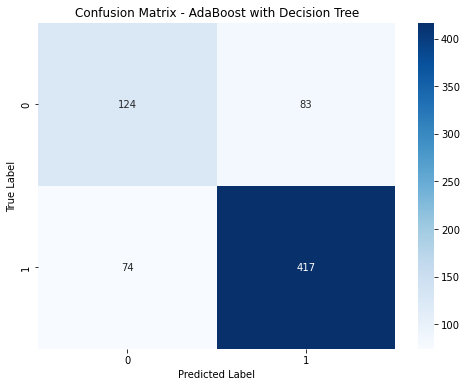

In [84]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the base classifier
base_estimator = DecisionTreeClassifier(max_depth=1)

# Initialize AdaBoost with a Decision Tree as the base estimator
ada_classifier = AdaBoostClassifier(n_estimators=50,
                                    learning_rate=1.0,
                                    random_state=42)

# Train the AdaBoost model
ada_classifier.fit(X_train, y_train)

# Prediction on the test set
predictions_ada = ada_classifier.predict(X_test)

# Calculate metrics
accuracy_ada = accuracy_score(y_test, predictions_ada)
recall_ada = recall_score(y_test, predictions_ada)

# Generating the confusion matrix
conf_matrix_ada = confusion_matrix(y_test, predictions_ada)

print("AdaBoost with Decision Tree Classifier Metrics:")
print("Accuracy:", accuracy_ada)
print("Recall score:", recall_ada)
print("Confusion Matrix:")
print(conf_matrix_ada)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ada, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - AdaBoost with Decision Tree")
plt.show()

In [85]:
# Save the predictions
dataset_with_predictions['DT+Ada AccumulationInvestment'] = predictions_ada
dataset_with_predictions.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,MLP AccumulationInvestment,RF AccumulationInvestment,LR AccumulationInvestment,KNN AccumulationInvestment,SVM AccumulationInvestment,GB AccumulationInvestment,DT+Ada AccumulationInvestment
179,0.518987,0.119366,0.166095,0.499077,0.447003,0.405424,1,0,1,1,1,0,0
2153,0.759494,0.568503,0.617078,0.902076,0.764515,0.381090,1,1,1,1,1,1,1
3234,0.582278,0.615310,0.398159,0.658283,0.661516,0.322413,0,1,1,1,1,1,0
184,0.582278,0.545493,0.482318,0.627178,0.580825,0.370585,1,1,1,1,1,1,1
1071,0.341772,0.610581,0.531877,0.845886,0.595056,0.487633,1,1,1,1,1,1,1


## Naïve Bayes

Naive Bayes Classifier Metrics:
Accuracy: 0.6948424068767909
Recall score: 0.9205702647657841
Confusion Matrix:
[[ 33 174]
 [ 39 452]]


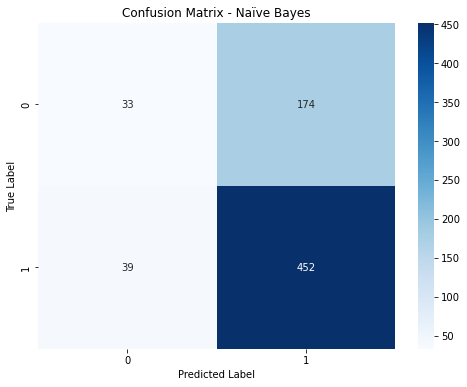

In [86]:
from sklearn.naive_bayes import GaussianNB

# Initialize the Naive Bayes classifier
nb_classifier = GaussianNB()

# Training the model
nb_classifier.fit(X_train, y_train)

# Prediction on the test set
predictions_nb = nb_classifier.predict(X_test)

# Calculate metrics
accuracy_nb = accuracy_score(y_test, predictions_nb)
recall_nb = recall_score(y_test, predictions_nb)

# Confusion Matrix
conf_matrix_nb = confusion_matrix(y_test, predictions_nb)

print("Naive Bayes Classifier Metrics:")
print("Accuracy:", accuracy_nb)
print("Recall score:", recall_nb)
print("Confusion Matrix:")
print(conf_matrix_nb)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Naïve Bayes")
plt.show()

In [87]:
# Save the predictions
dataset_with_predictions['NB AccumulationInvestment'] = predictions_nb
dataset_with_predictions.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,MLP AccumulationInvestment,RF AccumulationInvestment,LR AccumulationInvestment,KNN AccumulationInvestment,SVM AccumulationInvestment,GB AccumulationInvestment,DT+Ada AccumulationInvestment,NB AccumulationInvestment
179,0.518987,0.119366,0.166095,0.499077,0.447003,0.405424,1,0,1,1,1,0,0,1
2153,0.759494,0.568503,0.617078,0.902076,0.764515,0.381090,1,1,1,1,1,1,1,1
3234,0.582278,0.615310,0.398159,0.658283,0.661516,0.322413,0,1,1,1,1,1,0,1
184,0.582278,0.545493,0.482318,0.627178,0.580825,0.370585,1,1,1,1,1,1,1,1
1071,0.341772,0.610581,0.531877,0.845886,0.595056,0.487633,1,1,1,1,1,1,1,1


## XGBoost

XGBoost Classifier Metrics:
Accuracy: 0.7679083094555874
Recall score: 0.8615071283095723
Confusion Matrix:
[[113  94]
 [ 68 423]]


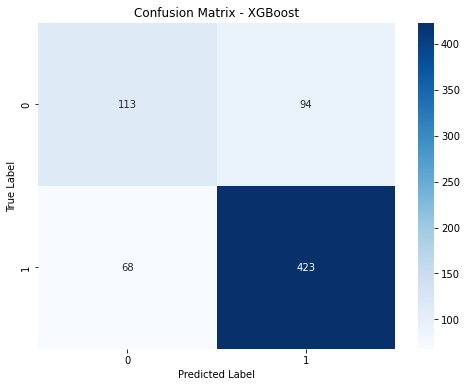

In [88]:
from xgboost import XGBClassifier

# Initialize the XGBoost classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Training the model
xgb_classifier.fit(X_train, y_train)

# Prediction on the test set
predictions_xgb = xgb_classifier.predict(X_test)

# Calculate metrics
accuracy_xgb = accuracy_score(y_test, predictions_xgb)
recall_xgb = recall_score(y_test, predictions_xgb)

# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test, predictions_xgb)

print("XGBoost Classifier Metrics:")
print("Accuracy:", accuracy_xgb)
print("Recall score:", recall_xgb)
print("Confusion Matrix:")
print(conf_matrix_xgb)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost")
plt.show()

In [89]:
# Save the predictions
dataset_with_predictions['XGB AccumulationInvestment'] = predictions_xgb
dataset_with_predictions.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,MLP AccumulationInvestment,RF AccumulationInvestment,LR AccumulationInvestment,KNN AccumulationInvestment,SVM AccumulationInvestment,GB AccumulationInvestment,DT+Ada AccumulationInvestment,NB AccumulationInvestment,XGB AccumulationInvestment
179,0.518987,0.119366,0.166095,0.499077,0.447003,0.405424,1,0,1,1,1,0,0,1,0
2153,0.759494,0.568503,0.617078,0.902076,0.764515,0.381090,1,1,1,1,1,1,1,1,1
3234,0.582278,0.615310,0.398159,0.658283,0.661516,0.322413,0,1,1,1,1,1,0,1,1
184,0.582278,0.545493,0.482318,0.627178,0.580825,0.370585,1,1,1,1,1,1,1,1,1
1071,0.341772,0.610581,0.531877,0.845886,0.595056,0.487633,1,1,1,1,1,1,1,1,1


## Bagging

In [90]:
# Predictions from the 5 models
predictions_from_models = dataset_with_predictions.iloc[:, -9:]

# Calculate the mode along the columns axis for each row
# Using the best classifiers in term of biggest recall -> MLP, IF, KNN, GB, XGBoost
bagging_predictions = predictions_from_models.iloc[:, [0, 1, 3, 5, 8]].mode(axis=1)

# Add 'Bagging' column to dataset_with_predictions DataFrame
dataset_with_predictions['Bagging'] = bagging_predictions.iloc[:, 0]
dataset_with_predictions.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Income/Wealth,MLP AccumulationInvestment,RF AccumulationInvestment,LR AccumulationInvestment,KNN AccumulationInvestment,SVM AccumulationInvestment,GB AccumulationInvestment,DT+Ada AccumulationInvestment,NB AccumulationInvestment,XGB AccumulationInvestment,Bagging
179,0.518987,0.119366,0.166095,0.499077,0.447003,0.405424,1,0,1,1,1,0,0,1,0,0
2153,0.759494,0.568503,0.617078,0.902076,0.764515,0.381090,1,1,1,1,1,1,1,1,1,1
3234,0.582278,0.615310,0.398159,0.658283,0.661516,0.322413,0,1,1,1,1,1,0,1,1,1
184,0.582278,0.545493,0.482318,0.627178,0.580825,0.370585,1,1,1,1,1,1,1,1,1,1
1071,0.341772,0.610581,0.531877,0.845886,0.595056,0.487633,1,1,1,1,1,1,1,1,1,1


Accuracy: 0.7808022922636103
Recall: 0.9124236252545825
Confusion Matrix
[[ 97 110]
 [ 43 448]]


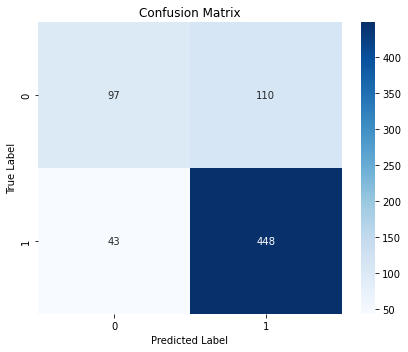

In [91]:
# Evaluating the overall model
accuracy_bagging = accuracy_score(y_test, dataset_with_predictions['Bagging'])
print("Accuracy:", accuracy_bagging)

recall_bagging = recall_score(y_test, dataset_with_predictions['Bagging'])
print("Recall:", recall_bagging)

conf_matrix = confusion_matrix(y_test, dataset_with_predictions['Bagging'])
print("Confusion Matrix")
print(conf_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.tight_layout()
plt.show()

**General comment:**  
  
In this classification part, it's observed that the negative class is frequently misclassified, while the positive class is misclassified less often.  
This imbalance in classification accuracy is likely attributed to the removal of 'uninterested' clients, resulting in a dataset that is skewed towards the positive class.  
While this imbalance may seem unfavorable from a traditional classification perspective, it's important to note that our primary objective is to target potential customers interested in purchasing our products.
Therefore, the higher accuracy in predicting the positive class, despite the imbalance, aligns well with our business goal of targeting interested customers for sales opportunities.








In [92]:
# Save the predictions dataset for the 'IncomeInvestment' label
excel_file_path = "AccumulationInvestment_Predicitons.xlsx"

dataset_with_predictions.to_excel(excel_file_path, index=False)